In [1]:
from pathlib import Path
import pandas as pd

import os
from google.colab import drive
from google.colab import auth
from google.auth import default

drive.mount('/content/drive/', force_remount=True)
os.chdir('/content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch')
DATA = Path("/content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data")

Mounted at /content/drive/


Build Per-Source Dataframes

In [2]:
from pathlib import Path
import pandas as pd

ROOT = Path("/content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data")
INT_AQ = ROOT/"interim/aquavplant"
INT_BD = ROOT/"interim/bangladesh_augmented"
OUT    = ROOT/"processed"; OUT.mkdir(parents=True, exist_ok=True)

# --- AqUavPlant (segmentation) ---
rows=[]
for img in sorted(INT_AQ.glob("image_*.jpg")):
    msk = img.with_suffix(".png")
    if msk.exists():
        rows.append(dict(
            image_path=str(img),
            mask_path=str(msk),
            has_hyacinth=1,
            source="aquavplant"
        ))
aqua_df = pd.DataFrame(rows)

# --- Bangladesh augmented (presence) ---
rows=[]
for cls in [d for d in INT_BD.iterdir() if d.is_dir()]:
    for p in cls.glob("*.jpg"):
        rows.append(dict(
            image_path=str(p),
            mask_path="",
            has_hyacinth=1 if ("Hyacinth" in cls.name or "Eichornia" in cls.name) else 0,
            species_name=cls.name,
            source="bangladesh_augmented"
        ))
bd_df = pd.DataFrame(rows)

# Base stem used for group-aware splitting (all _aug* variants share the same base)
from pathlib import Path as _P
if not bd_df.empty:
    bd_df["base_stem"] = bd_df["image_path"].apply(lambda x: _P(x).stem.split("_aug")[0])

print("AqUavPlant pairs:", len(aqua_df))
print("Bangladesh (aug) images:", len(bd_df))

AqUavPlant pairs: 206
Bangladesh (aug) images: 4050


### Helpers for Group-Aware Stratified Splits

In [3]:
import numpy as np

def sgkfold_splits(df, label_col, group_col, test_size=0.15, val_size=0.15, random_state=42):
    """
    Split df into train/val/test USING StratifiedGroupKFold on groups.
    Returns a 'split' column indexed to df.index.
    """
    try:
        from sklearn.model_selection import StratifiedGroupKFold
        sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state)

        # 1) choose TEST groups ≈ test_size
        groups = df[group_col].values
        y      = df[label_col].values
        # iterate folds and pick one whose proportion is closest to desired test_size
        best_fold, best_gap = None, 1e9
        for fold_id, (_, te_idx) in enumerate(sgkf.split(np.zeros_like(y), y, groups)):
            prop = len(te_idx)/len(df)
            gap  = abs(prop - test_size)
            if gap < best_gap:
                best_fold, best_gap = te_idx, gap
        test_idx = best_fold

        # 2) split the remaining groups into train/val
        remain = df.drop(df.index[test_idx])
        groups_r = remain[group_col].values
        y_r      = remain[label_col].values

        sgkf2 = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=random_state+1)
        best_fold2, best_gap2 = None, 1e9
        for _, va_idx in sgkf2.split(np.zeros_like(y_r), y_r, groups_r):
            prop = len(va_idx)/len(remain)
            gap  = abs(prop - val_size/(1.0 - test_size))
            if gap < best_gap2:
                best_fold2, best_gap2 = va_idx, gap
        val_idx = remain.index[best_fold2]
        train_idx = remain.index.difference(val_idx)

        out = pd.Series("train", index=df.index)
        out.loc[val_idx]  = "val"
        out.loc[test_idx] = "test"
        return out
    except Exception as e:
        # Fallback: GroupShuffleSplit (not strictly stratified, but group-safe)
        from sklearn.model_selection import GroupShuffleSplit
        gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
        groups = df[group_col].values
        y      = df[label_col].values  # not used here
        tr_idx, te_idx = next(gss.split(df, groups=groups))
        remain = df.iloc[tr_idx]
        gss2 = GroupShuffleSplit(n_splits=1, test_size=val_size/(1.0-test_size), random_state=random_state+1)
        tr2_idx, va_idx = next(gss2.split(remain, groups=remain[group_col].values))
        out = pd.Series("train", index=df.index)
        out.iloc[va_idx] = "val"
        out.iloc[te_idx] = "test"
        return out

### Apply Splits (AqUavPlant = regular; Bangladesh = group-aware)

In [4]:
from sklearn.model_selection import train_test_split

# --- AqUavPlant (random split) ---
if not aqua_df.empty:
    aq_idx = aqua_df.index
    tr, te = train_test_split(aq_idx, test_size=0.15, random_state=42)
    tr, va = train_test_split(tr, test_size=0.15, random_state=42)
    aqua_df["split"] = "train"
    aqua_df.loc[va, "split"] = "val"
    aqua_df.loc[te, "split"] = "test"

# --- Bangladesh (group-aware, leak-proof) ---
if not bd_df.empty:
    bd_df["split"] = sgkfold_splits(
        bd_df, label_col="has_hyacinth", group_col="base_stem",
        test_size=0.15, val_size=0.15, random_state=42
    )

# Merge and write
df = pd.concat([aqua_df, bd_df], ignore_index=True)
df.to_csv(OUT/"metadata.csv", index=False)

print("Saved:", OUT/"metadata.csv")
print(df["source"].value_counts())
print(df.groupby(["source","split"]).size())

Saved: /content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/processed/metadata.csv
source
bangladesh_augmented    4050
aquavplant               206
Name: count, dtype: int64
source                split
aquavplant            test       31
                      train     148
                      val        27
bangladesh_augmented  test      804
                      train    2603
                      val       643
dtype: int64


### Quick Sanity Check (No Leakage)

In [5]:
# 1) No base_stem crossing splits
if "base_stem" in df.columns:
    bd = df.query("source=='bangladesh_augmented'").copy()
    cross = (
        bd.groupby("base_stem")["split"]
          .nunique()
          .reset_index(name="n")
    )
    leaked = int((cross["n"] > 1).sum())
    print(f"Leak check — base_stem spanning multiple splits: {leaked}")
    assert leaked == 0, "Leak detected: some base_stem appear in multiple splits!"

# 2) Class balance per split (Bangladesh)
if not bd_df.empty:
    print(
        df.query("source=='bangladesh_augmented'")
          .groupby("split")["has_hyacinth"]
          .value_counts()
    )

Leak check — base_stem spanning multiple splits: 0
split  has_hyacinth
test   0                606
       1                198
train  0               1960
       1                643
val    0                484
       1                159
Name: count, dtype: int64


### Class Balance Per-Split (Bar-Chart)

/tmp/ipython-input-2813921098.py:19: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  ys = [int(sub[sub["has_hyacinth"]==0]["count"]), int(sub[sub["has_hyacinth"]==1]["count"])]


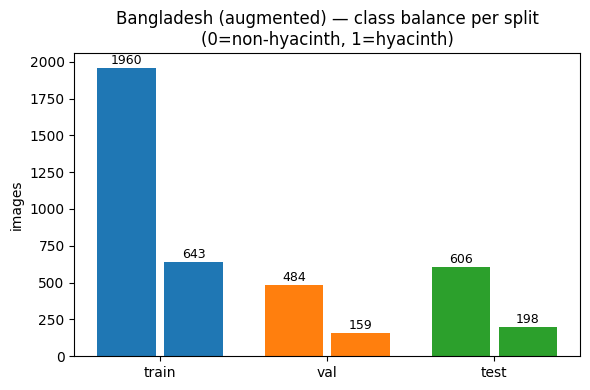

In [7]:
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

CSV = Path("/content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/processed/metadata.csv")
df = pd.read_csv(CSV)

bd = df.query("source=='bangladesh_augmented'").copy()
counts = (
    bd.groupby(["split","has_hyacinth"])
      .size()
      .reset_index(name="count")
      .sort_values(["split","has_hyacinth"])
)

plt.figure(figsize=(6,4))
for i, sp in enumerate(["train","val","test"]):
    sub = counts[counts["split"]==sp]
    xs = [0,1]
    ys = [int(sub[sub["has_hyacinth"]==0]["count"]), int(sub[sub["has_hyacinth"]==1]["count"])]
    plt.bar([i-0.2, i+0.2], ys, width=0.35)
    plt.text(i-0.2, ys[0]+5, str(ys[0]), ha="center", va="bottom", fontsize=9)
    plt.text(i+0.2, ys[1]+5, str(ys[1]), ha="center", va="bottom", fontsize=9)

plt.xticks([0,1,2], ["train","val","test"])
plt.ylabel("images")
plt.title("Bangladesh (augmented) — class balance per split\n(0=non-hyacinth, 1=hyacinth)")
plt.tight_layout(); plt.show()

### Quick image grid from each split (shows class + base_stem)

In [8]:
import numpy as np, matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

def show_grid(frame, n=8, title=""):
    frame = frame.sample(min(n, len(frame)), random_state=42)
    cols = 4
    rows = int(np.ceil(len(frame)/cols))
    plt.figure(figsize=(3.5*cols, 3.2*rows))
    for i, (_,r) in enumerate(frame.iterrows()):
        ax = plt.subplot(rows, cols, i+1)
        img = Image.open(r.image_path).convert("RGB")
        ax.imshow(img); ax.axis("off")
        stem = Path(r.image_path).stem.split("_aug")[0]
        lbl  = int(r.has_hyacinth)
        ax.set_title(f"y={lbl}  •  {stem}", fontsize=9)
    plt.suptitle(title); plt.tight_layout(); plt.show()

show_grid(bd.query("split=='train'"), n=8, title="TRAIN — random samples")
show_grid(bd.query("split=='val'"),   n=8, title="VAL — random samples")
show_grid(bd.query("split=='test'"),  n=8, title="TEST — random samples")

Output hidden; open in https://colab.research.google.com to view.

### Leak detector” Visual (only shows something if leakage exists)

In [9]:
# Find any base_stem that appears in more than one split; if found, visualize first few.
cross = (
    bd.assign(base_stem=bd["image_path"].apply(lambda x: Path(x).stem.split("_aug")[0]))
      .groupby("base_stem")["split"].nunique()
      .reset_index(name="n")
)
leaky_stems = set(cross[cross["n"]>1]["base_stem"])

if leaky_stems:
    print("⚠️ Found leaked stems across splits:", list(leaky_stems)[:5])
    leak_df = bd[bd["image_path"].apply(lambda x: Path(x).stem.split("_aug")[0]).isin(leaky_stems)]
    # show up to 8 leaked examples
    show_grid(leak_df.head(8), n=8, title="⚠️ Leaked stems across splits (should be empty)")
else:
    print("✅ No leaked stems detected. Visual leak check skipped.")

✅ No leaked stems detected. Visual leak check skipped.
